In [180]:
import os
from os.path import join
import pandas as pd
from tqdm import tqdm
from geopy.geocoders import Nominatim
from statistics import mean
import numpy as np
from matplotlib import pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go

In [14]:
def get_locations(address, zip_code):
    try:
        # This removes information about a flats storey
        address_field = address.split(', ')[0]
        # This one removes trailing letters on the city name
        # It seems as if Openstreetmap cannot handle København H
        # but it works with København
        zip_field = ' '.join(zip_code.split(' ')[:-1])
        search_address = ', '.join([address_field, zip_field])

        geolocator = Nominatim()
        location = geolocator.geocode(search_address)
        return location.latitude, location.longitude
    except:
        print('Skipped geocoding of {} {}'.format(address, zip_code))
        return None, None

In [65]:
def haversine_distance(origin, destination):

    lat_orig, lon_orig = origin
    lat_dest, lon_dest = destination
    radius = 6371

    dlat = math.radians(lat_dest-lat_orig)
    dlon = math.radians(lon_dest-lon_orig)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat_orig)) 
        * math.cos(math.radians(lat_dest)) * math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [3]:
def remove_city_name(zip_code):
    return ' '.join(zip_code.split(' ')[:-2])

In [4]:
def create_data_frame():
    li = []
    for filename in os.listdir('./boliga_stats'):
        #filename = os.path.join(os.getcwd(),filename)
        df = pd.read_csv(os.path.join('./boliga_stats',filename), index_col=None, header=0)
        li.append(df)

    return pd.concat(li, axis=0, ignore_index=True)

In [5]:
def create_city_csv(dataframe, year):
    cities = {
              'Odense': '5000',
              'København': '1049',
              'Aarhus': '8000',
              'Aalborg': '9000'}
    folder_path = join(os.getcwd(),year)          
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        
    for city in cities:
        mask = (dataframe['zip_code_num'] == cities[city])
        dataf = dataframe[mask]
        dataf.to_csv('./' + year + '/' + city + ".csv", index=False,encoding='utf-8')

In [6]:
def calulate_avg_year(df,mask,year,zipcode):
    temp = df[mask]
    temp = temp.dropna(subset=['price_per_sq_m'])
    if not temp.empty:
        print('Average price per square meter for the zip code {} in the year {} is {} pr. m\u00b2\n'.format(
            zipcode,year,mean(temp['price_per_sq_m'])))
    else:
        print('Average price per square meter for the zip code {} in the year {} is {} pr. m\u00b2\n'.format(
            zipcode,year,0))
    

### Read the entire dataset of Danish housing sales data, from Boliga

In [7]:
# creates the dataframe.
df = create_data_frame()

### Geocode the the entire dataset of Danish housing sales data

In [147]:
geocode = df.sample(n=40,replace=True, random_state=42)
geocode['lat'],geocode['long']= zip(*geocode.apply (lambda row: get_locations(row['address'].split(',')[0],row['zip_code']), axis=1))

/Users/pravien/Documents/Software_dev/semester_2/bi/venv-bi/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning:

Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.



Skipped geocoding of Plastvænget 10 9560 Hadsund
Skipped geocoding of Håstrupvej 14 7000 Fredericia
Skipped geocoding of Avlumvej 6 7400 Herning
Skipped geocoding of Ydbyvej 176 7760 Hurup Thy
Skipped geocoding of Gl Skansevej 21 9370 Hals


In [148]:
# removing values where the lattitude and longitude is None.
geocode = geocode.dropna()

### Convert all sales dates in the dataset into proper datetime objects

In [107]:
df['sell_date'] = pd.to_datetime(df['sell_date'],format='%d-%m-%Y')

### Compute the average price per square meter for the years 1992 and 2016

In [108]:
# Create a  new column which only contain the zip code.
df['zip_code_num'] = df.apply(lambda x: remove_city_name(x['zip_code']), axis=1)

In [214]:
#Generate the masks we need. 
mask_1992 = ((df['sell_date'].dt.year == 1992) & 
     ((df['zip_code_num'] == '1050') | (df['zip_code_num'] == '1049') | (df['zip_code_num'] == '5000') | 
     (df['zip_code_num'] == '8000') | (df['zip_code_num'] == '9000'))
     )


mask_2016 = ((df['sell_date'].dt.year == 2016) & 
     ((df['zip_code_num'] == '1050') | (df['zip_code_num'] == '1049') | (df['zip_code_num'] == '5000') | 
     (df['zip_code_num'] == '8000') | (df['zip_code_num'] == '9000'))
     )


mask_1992_1050_1049 = ((df['sell_date'].dt.year == 1992) & 
     ((df['zip_code_num'] == '1050') | (df['zip_code_num'] == '1049')))

mask_1992_5000 = ((df['sell_date'].dt.year == 1992) & 
     ((df['zip_code_num'] == '5000')))  
                  
mask_1992_8000 = ((df['sell_date'].dt.year == 1992) & 
     ((df['zip_code_num'] == '8000')))    

mask_1992_9000 = ((df['sell_date'].dt.year == 1992) & 
     ((df['zip_code_num'] == '9000')))


mask_2016_1050_1049 = ((df['sell_date'].dt.year == 2016) & 
     ((df['zip_code_num'] == '1050') | (df['zip_code_num'] == '1049')))

mask_2016_5000 = ((df['sell_date'].dt.year == 2016) & 
     ((df['zip_code_num'] == '5000')))

mask_2016_8000 = ((df['sell_date'].dt.year == 2016) & 
     ((df['zip_code_num'] == '8000')))

mask_2016_9000 = ((df['sell_date'].dt.year == 2016) & 
     ((df['zip_code_num'] == '9000')))

                  

In [220]:
masks = [
    (mask_1992_1050_1049,'1050-1049','1992'),
    (mask_1992_5000,'5000','1992'),
    (mask_1992_8000,'8000','1992'),
    (mask_1992_9000,'9000','1992'),
    (mask_2016_1050_1049,'1050-1049','2016'),
    (mask_2016_5000,'5000','2016'),
    (mask_2016_8000,'8000','2016'),
    (mask_2016_9000,'9000','2016')
]

In [225]:
for mask,zip_code,year in masks:
    calulate_avg_year(df,mask,year,zip_code)

Average price per square meter for the zip code 1050-1049 in the year 1992 is 0 pr. m²

Average price per square meter for the zip code 5000 in the year 1992 is 5452.180722891566 pr. m²

Average price per square meter for the zip code 8000 in the year 1992 is 7172.0327868852455 pr. m²

Average price per square meter for the zip code 9000 in the year 1992 is 0 pr. m²

Average price per square meter for the zip code 1050-1049 in the year 2016 is 0 pr. m²

Average price per square meter for the zip code 5000 in the year 2016 is 19378.44211994421 pr. m²

Average price per square meter for the zip code 8000 in the year 2016 is 33120.19696969697 pr. m²

Average price per square meter for the zip code 9000 in the year 2016 is 0 pr. m²



In [226]:
#Calculate the average square meter prices.
df_2016 = df[mask_2016]
df_1992 = df[mask_1992]

df_2016 = df_2016.dropna(subset=['price_per_sq_m'])
df_1992 = df_1992.dropna(subset=['price_per_sq_m'])
print('Average price per square meter for the year 1992 is {} pr. m\u00b2'.format(mean(df_1992['price_per_sq_m'])))
print('Average price per square meter for the year 2016 is {} pr. m\u00b2'.format(mean(df_2016['price_per_sq_m'])))

Average price per square meter for the year 1992 is 6180.729166666667 pr. m²
Average price per square meter for the year 2016 is 28711.76823266219 pr. m²


### Create, with the help of the pandas module, four new CSV files containing the sales data for the year 1992 for the city centers of Copenhagen (zip code 1050-1049), Odense (zip code 5000), Aarhus (zip code 8000), and Aalborg (zip code 9000)

In [192]:
# Create two folder one for each year containing a csv for each of the zip codes specified in the assignment.
create_city_csv(df[mask_1992], '1992')
create_city_csv(df[mask_2016], '2016')

### Create a 2-dimensional scatter plot, which contains a dot for each location in the dataset of Danish housing sales data. Plot the longitude values on the x- axis and plot the latitude values on the y-axis.

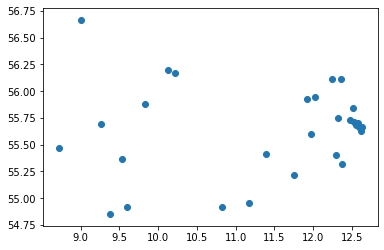

In [67]:
%matplotlib inline
plt.scatter(geocode['long'],geocode['lat'])

### computes the Haversine Distance

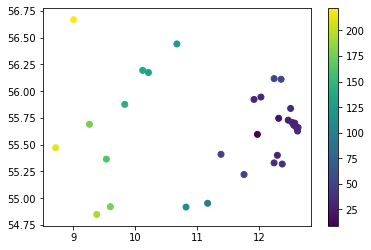

In [151]:
distances = []
for i in zip(geocode.lat,geocode.long):
    distances.append(haversine_distance(i,(55.65, 12.083333)))
plt.scatter(geocode['long'],geocode['lat'],c=distances) 
plt.colorbar()

### Plot on map

In [177]:
geocode['distance'] = distances
geocode['text'] = geocode['address'] + ' ' +geocode['zip_code']
fig = go.Figure(data=go.Scattergeo(
        lon = geocode['long'],
        lat = geocode['lat'],
        text = geocode['text'],
        mode = 'markers',
        marker_color = geocode['distance'],
        ))

In [179]:
fig.update_layout(
        title = 'Map',
        geo_scope='europe',
    )